In [10]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore") 

from matplotlib import test
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import Counter
from pretty_confusion_matrix import pp_matrix #pip install pretty_confusion_matrix

import json
import matplotlib.pyplot as plt
import gzip
import pandas as pd
import copy
import os
import numpy as np
from fpdf import FPDF #pip install fpdf2 #pip install fpdf
from PIL import Image

# Part 1

In [11]:
sentiments = []
emotions = []
comments = []

commentsTrainVector = None
commentsTestVector = None

In [12]:
#1.2
emotionsGZIP = gzip.open("./goemotions.json.gz", "rb")
emotionsJSON = json.load(emotionsGZIP)

In [13]:
def createPieChart(dict, dictName):
    labels = []
    values = []
    for x,y in dict.items():
        labels.append(x)
        values.append(y)
    plt.pie(values, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(values)/100 :.0f}')
    plt.savefig(fname='./graphs/'+dictName+'.pdf', format='pdf')
    plt.clf()
    

In [14]:
#1.3
for value in emotionsJSON:
        emotions.append(value[1])
        sentiments.append(value[2])
        comments.append(value[0])

createPieChart(Counter(emotions), 'emotions_with_values')
createPieChart(Counter(sentiments), 'sentiments_with_values')

<Figure size 640x480 with 0 Axes>

# Part 2

In [15]:
#2.1
vectorizer = CountVectorizer()
X  = vectorizer.fit(comments)
print("Vocabulary size: ", len(X.vocabulary_))

Vocabulary size:  30449


In [16]:
#2.2
comments_train, comments_test, sentiments_train, sentiments_test, emotions_train, emotions_test = train_test_split(comments, sentiments, emotions, test_size=0.2, random_state=0)

## 2.3

In [28]:
#2.3
vectorizer = CountVectorizer()
commentsTrainVector = vectorizer.fit_transform(comments_train)
commentsTestVector = vectorizer.transform(comments_test)


def getBaseClassifiersPredictions(classifier, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train):

    #emotions
    classifier.fit(commentsTrainVector, emotions_train)
    emotions_classifier = copy.deepcopy(classifier)
    emotions_pred = classifier.predict(commentsTestVector)
    print(emotions_pred)

    #sentiments
    classifier.fit(commentsTrainVector, sentiments_train)
    sentiments_classifier = copy.deepcopy(classifier)
    sentiments_pred = classifier.predict(commentsTestVector)
    print(sentiments_pred)

    return emotions_pred, sentiments_pred, emotions_classifier, sentiments_classifier

def getGridSearchWithModelAndParams(model, params, cvCount, jobs, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train):
    #Setup GridSearch and hyperparams
    tunedClassifier = GridSearchCV(model, params, cv=cvCount, n_jobs=jobs)
    hyperparams = list(params.keys())
    hyperparamsWithParams = ['param_' + paramInList for paramInList in hyperparams]
    
    #emotions
    tunedClassifier.fit(commentsTrainVector, emotions_train)
    emotions_tunedClassifier = copy.deepcopy(tunedClassifier)
    emotions_cv_results = tunedClassifier.cv_results_
    df = pd.DataFrame(emotions_cv_results)
    
    emotions_pred = tunedClassifier.predict(commentsTestVector)
    
    print(df[hyperparamsWithParams])
    print(tunedClassifier.best_score_)
    print(tunedClassifier.best_params_)
    print(tunedClassifier.predict(commentsTestVector))

    #sentiments
    tunedClassifier.fit(commentsTrainVector, sentiments_train)
    sentiments_tunedClassifier = copy.deepcopy(tunedClassifier)
    sentiments_cv_results = tunedClassifier.cv_results_
    df = pd.DataFrame(sentiments_cv_results)

    sentiments_pred = tunedClassifier.predict(commentsTestVector)
    
    print(df[hyperparamsWithParams])
    print(tunedClassifier.best_score_)
    print(tunedClassifier.best_params_)
    print(tunedClassifier.predict(commentsTestVector))

    return emotions_pred, sentiments_pred, emotions_tunedClassifier, sentiments_tunedClassifier

In [18]:
#2.3.1
emotions_baseMNB_pred, sentiments_baseMNB_pred, emotions_baseMNB_classifier, sentiments_baseMNB_classifier = getBaseClassifiersPredictions(MultinomialNB(), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [19]:
#2.3.2
emotions_baseDT_pred, sentiments_baseDT_pred, emotions_baseDT_classifier, sentiments_baseDT_classifier = getBaseClassifiersPredictions(DecisionTreeClassifier(), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

['curiosity' 'approval' 'annoyance' ... 'neutral' 'disapproval' 'neutral']
['ambiguous' 'positive' 'negative' ... 'neutral' 'negative' 'neutral']


In [27]:
#2.3.3
emotions_baseMLP_pred, sentiments_baseMLP_pred, emotions_baseMLP_classifier, sentiments_baseMLP_classifier = getBaseClassifiersPredictions(MLPClassifier(max_iter=2), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [21]:
 #2.3.4
mnb_classifier = MultinomialNB()
mnb_params = {
    'alpha': [0, 0.5, 1, 10]
    }
emotions_topMNB_pred, sentiments_topMNB_pred, emotions_topMNB_classifier, sentiments_topMNB_classifier = getGridSearchWithModelAndParams(mnb_classifier, mnb_params, 10, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

  param_alpha
0           0
1         0.5
2           1
3          10
0.3887716756068646
{'alpha': 0.5}
['neutral' 'neutral' 'confusion' ... 'neutral' 'neutral' 'neutral']
  param_alpha
0           0
1         0.5
2           1
3          10
0.5424208366551767
{'alpha': 1}
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [22]:
#2.3.5
dt_classifier = DecisionTreeClassifier()
dt_params = {
    'criterion': ['entropy'], # explain why gini or entropy https://quantdare.com/decision-trees-gini-vs-entropy/
    'max_depth': [1500, 1800],
    'min_samples_split': [4,6,8]
}
emotions_topDT_pred, sentiments_topDT_pred, emotions_topDT_classifier, sentiments_topDT_classifier = getGridSearchWithModelAndParams(dt_classifier, dt_params, 5, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

  param_criterion param_max_depth param_min_samples_split
0         entropy            1500                       4
1         entropy            1500                       6
2         entropy            1500                       8
3         entropy            1800                       4
4         entropy            1800                       6
5         entropy            1800                       8
0.34883163381544613
{'criterion': 'entropy', 'max_depth': 1800, 'min_samples_split': 8}
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
  param_criterion param_max_depth param_min_samples_split
0         entropy            1500                       4
1         entropy            1500                       6
2         entropy            1500                       8
3         entropy            1800                       4
4         entropy            1800                       6
5         entropy            1800                       8
0.5273760422197192
{'criterion': '

In [23]:
#2.3.6
mlp_classifier = MLPClassifier()
mlp_params = {
    'activation': ['logistic', 'tanh', 'relu', 'identity'],
    'hidden_layer_sizes': [(60, 80), (20, 20, 20)],
    'solver': ['adam', 'sgd'],
    'max_iter': [2]
    }
emotions_topMLP_pred, sentiments_topMLP_pred, emotions_topMLP_classifier, sentiments_topMLP_classifier = getGridSearchWithModelAndParams(mlp_classifier, mlp_params, 5, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

   param_activation param_hidden_layer_sizes param_solver param_max_iter
0          logistic                 (60, 80)         adam              2
1          logistic                 (60, 80)          sgd              2
2          logistic             (20, 20, 20)         adam              2
3          logistic             (20, 20, 20)          sgd              2
4              tanh                 (60, 80)         adam              2
5              tanh                 (60, 80)          sgd              2
6              tanh             (20, 20, 20)         adam              2
7              tanh             (20, 20, 20)          sgd              2
8              relu                 (60, 80)         adam              2
9              relu                 (60, 80)          sgd              2
10             relu             (20, 20, 20)         adam              2
11             relu             (20, 20, 20)          sgd              2
12         identity                 (60, 80)       

## 2.4

In [24]:

def getNewNameFileInPrecisionFolder(fName, extension):
    i = 0
    fullFileName = "./precision/"+fName+"_%s"+extension
    while os.path.exists( fullFileName % i):
        i += 1

    return fullFileName%i

def generateConfusionMatrix(clf, y_test, y_pred, figureFileName):
    #get confusion_matrix
    cm =  confusion_matrix(y_test,y_pred)
    
    #Create graph
    cmd = ConfusionMatrixDisplay( confusion_matrix = cm, display_labels= clf.classes_)
    fig, ax = plt.subplots(figsize=(15,15))

    cmd.plot(cmap=plt.cm.Blues, ax= ax, xticks_rotation='vertical')

    figurePath = getNewNameFileInPrecisionFolder('confusion_matrix_figures/'+figureFileName, '.png')
    
    #Save graph
    cmd.figure_.savefig(figurePath)

    return cm, figurePath

def generateClassificationReport(clf, y_test, y_pred, reportFileName):
    report = classification_report(y_test, y_pred, labels= clf.classes_)

    #Create file
    filePath = getNewNameFileInPrecisionFolder('classification_reports/'+reportFileName, '.txt')
    fo = open(filePath, 'wb')
    fo.write(str.encode(report))
    fo.close()
    return report, filePath


def addImage(pdf, path):
    cover = Image.open(path)
    width, height = cover.size
    width, height = float(width * 0.264583), float(height * 0.264583)
    pdf.add_page(format=(width, height))
    pdf.image(path, 0, 0, width, height)

def createPrecisionReport(modelName=None, hyperParams=None, emotions_pred=None, sentiments_pred=None, emotions_classifier=None, sentiments_classifier=None, emotions_test= emotions_test, sentiments_test= sentiments_test):
    
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font(family='Arial', size=14)
    
    #Description
    pdf.multi_cell(0, 5,'Model: \t'+modelName+'\n')
    pdf.multi_cell(0, 5,'HyperParams: \n')
    if hyperParams is not None:
        pdf.multi_cell(0, 5,json.dumps(hyperParams, indent=4)+'\n')
    pdf.multi_cell(0, 5,'\n')

    #Emotions
    cm_emotions, figurePath_emotions = generateConfusionMatrix(emotions_classifier, emotions_test, emotions_pred, modelName+'_emotions')
    report_emotions, reportPath_emotions = generateClassificationReport(emotions_classifier, emotions_test, emotions_pred, modelName)

    pdf.multi_cell(0, 5,'Classifications: Emotions\n')
    pdf.multi_cell(0, 5,'Confusion Matrix:\n')
    pdf.multi_cell(0, 5,'View Visual matrix at: ' + figurePath_emotions +'\n', align='L')
    pdf.multi_cell(0, 5, np.array2string(cm_emotions)+'\n')
    pdf.multi_cell(0, 5,'Classsification Report:\n')
    pdf.multi_cell(0, 5,'View formatted classification report at: ' + reportPath_emotions +'\n', align='L')
    pdf.multi_cell(0, 5, report_emotions+'\n')

    #Sentiments
    pdf.add_page()
    cm_sentiments, figurePath_sentiments = generateConfusionMatrix(sentiments_classifier, sentiments_test, sentiments_pred, modelName+'_sentiments')
    report_sentiments, reportPath_sentiments = generateClassificationReport(sentiments_classifier, sentiments_test, sentiments_pred, modelName)

    pdf.multi_cell(0, 5,'Classifications: Emotions\n')
    pdf.multi_cell(0, 5,'Confusion Matrix:\n')
    pdf.multi_cell(0, 5,'View Visual matrix at: ' + figurePath_sentiments +'\n', align='L')
    pdf.multi_cell(0, 5, np.array2string(cm_sentiments)+'\n')
    pdf.multi_cell(0, 5,'Classsification Report:\n')
    pdf.multi_cell(0, 5,'View formatted classification report at: ' + reportPath_sentiments +'\n', align='L')
    pdf.multi_cell(0, 5, report_sentiments+'\n')
    filePath = getNewNameFileInPrecisionFolder(modelName, '.pdf')

    #Create file
    pdf.output(filePath, 'F')


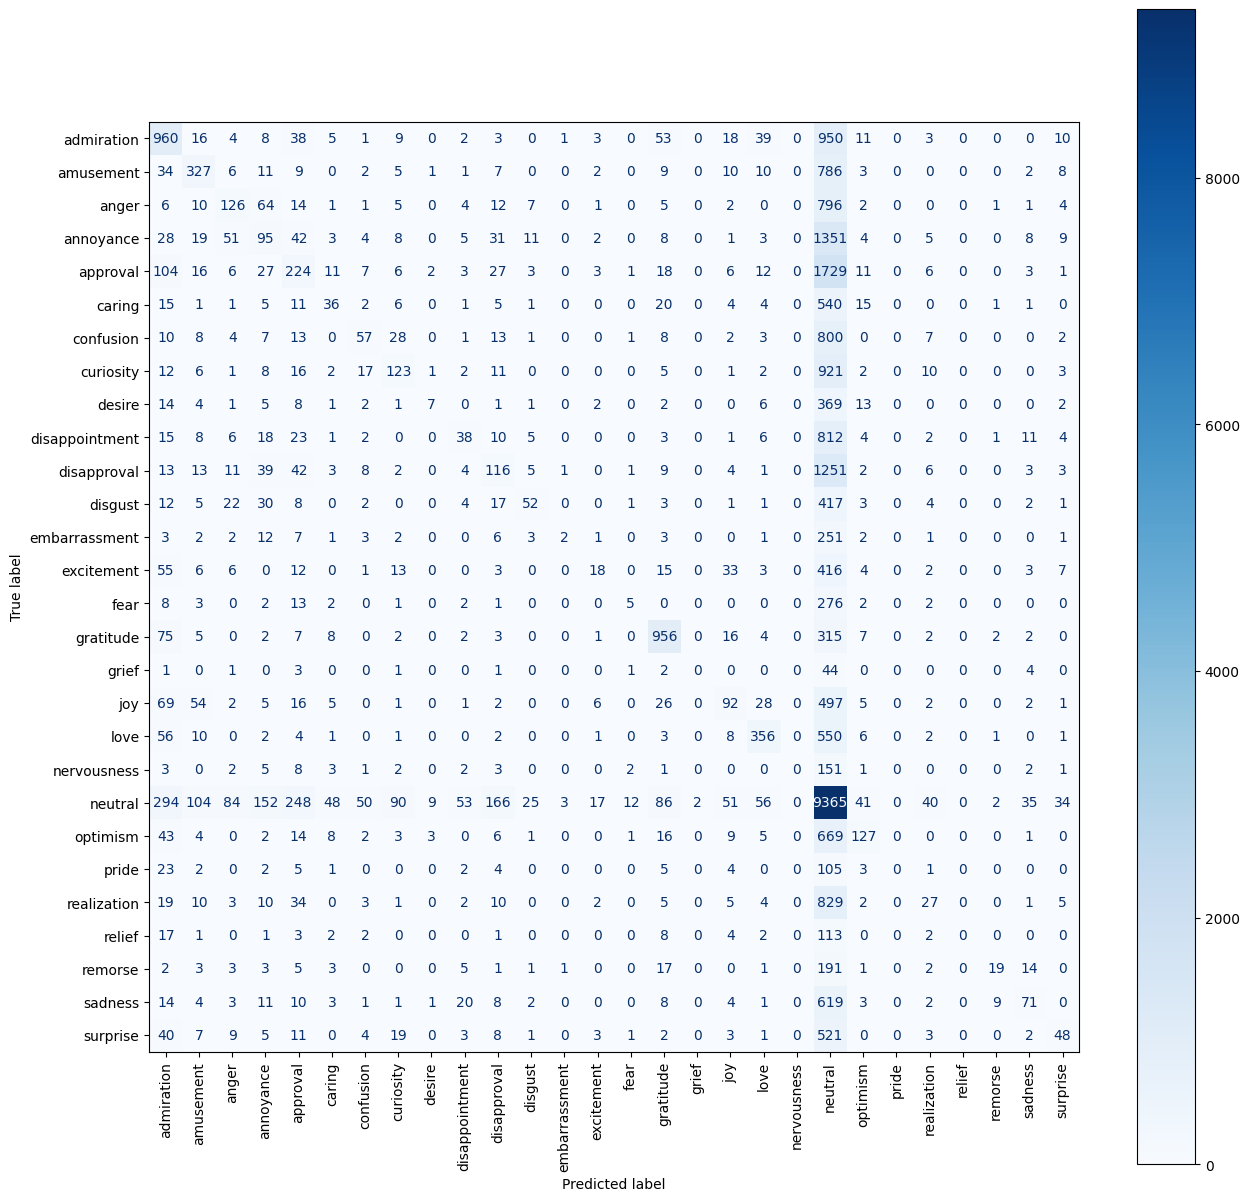

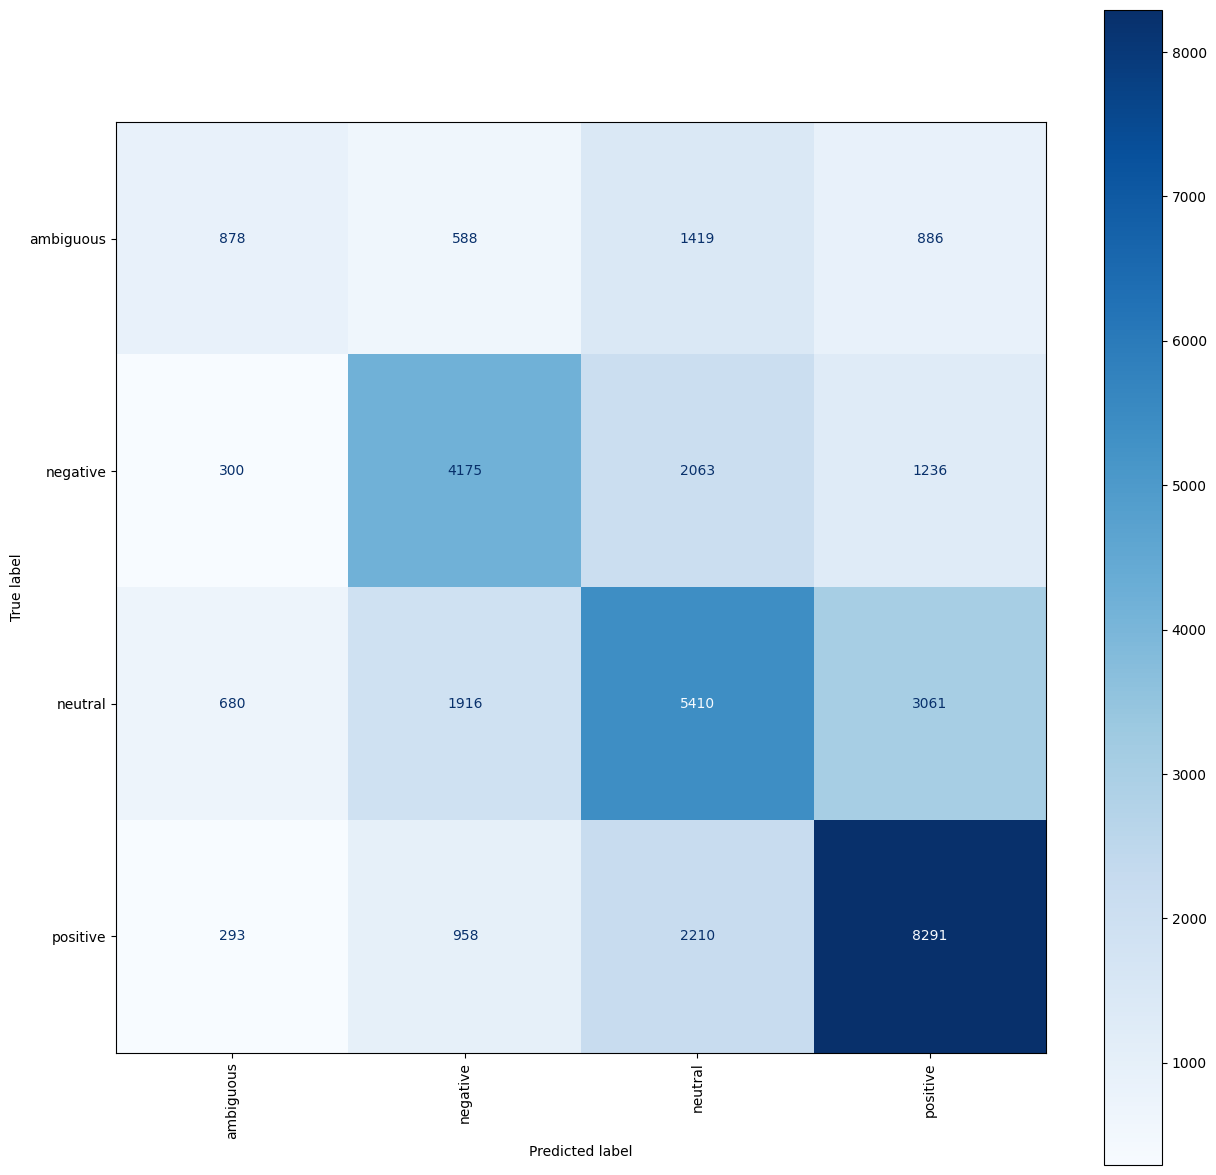

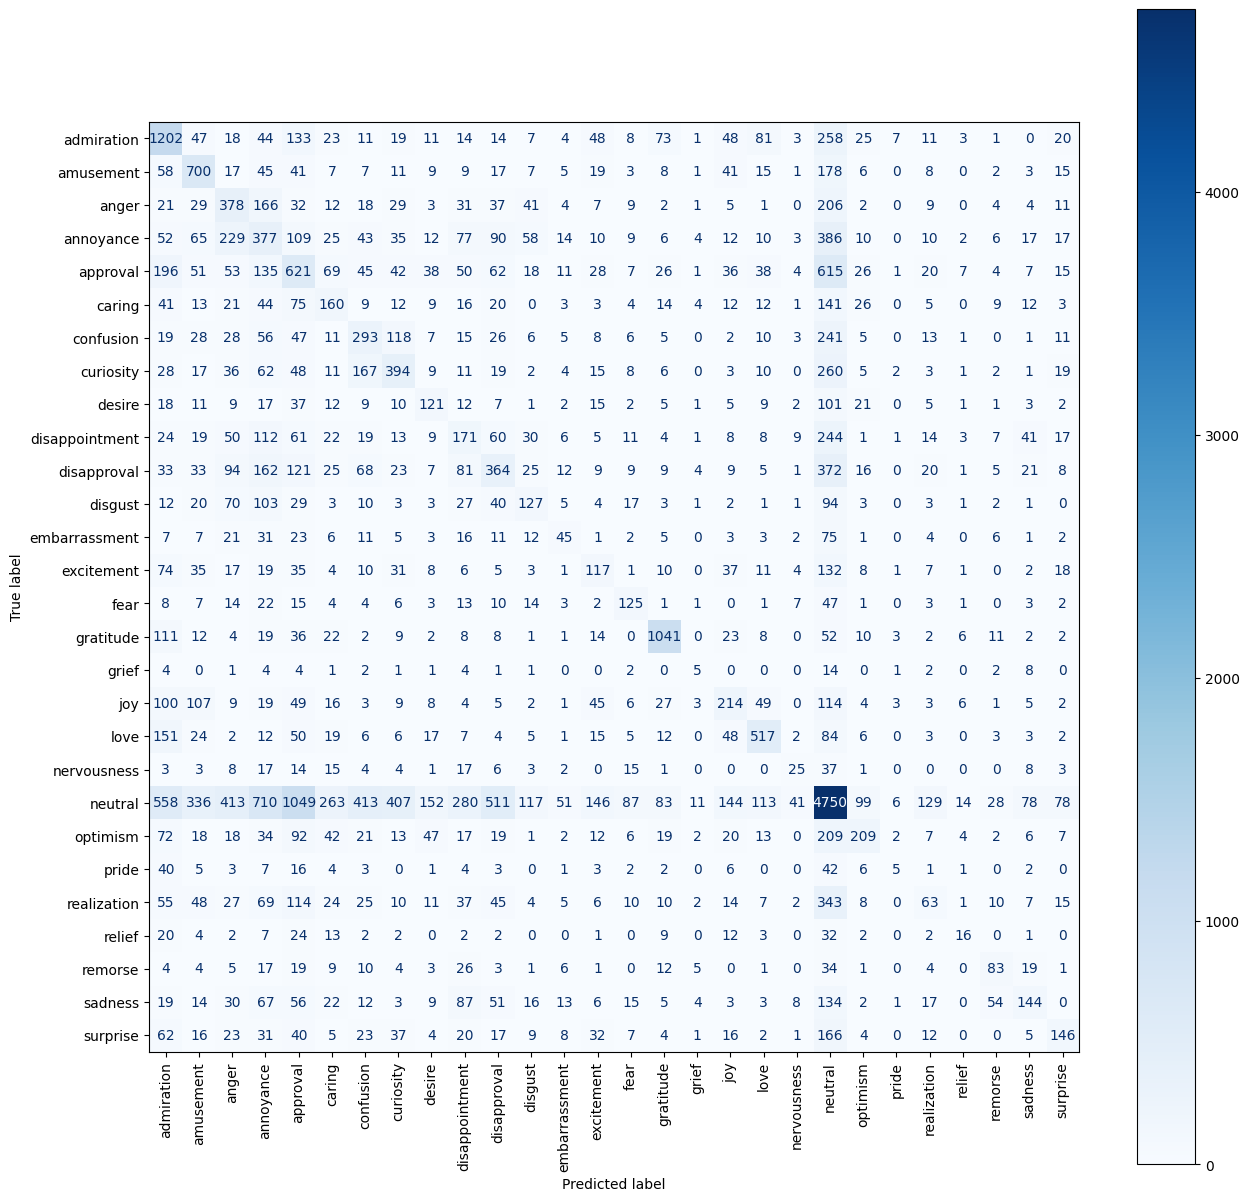

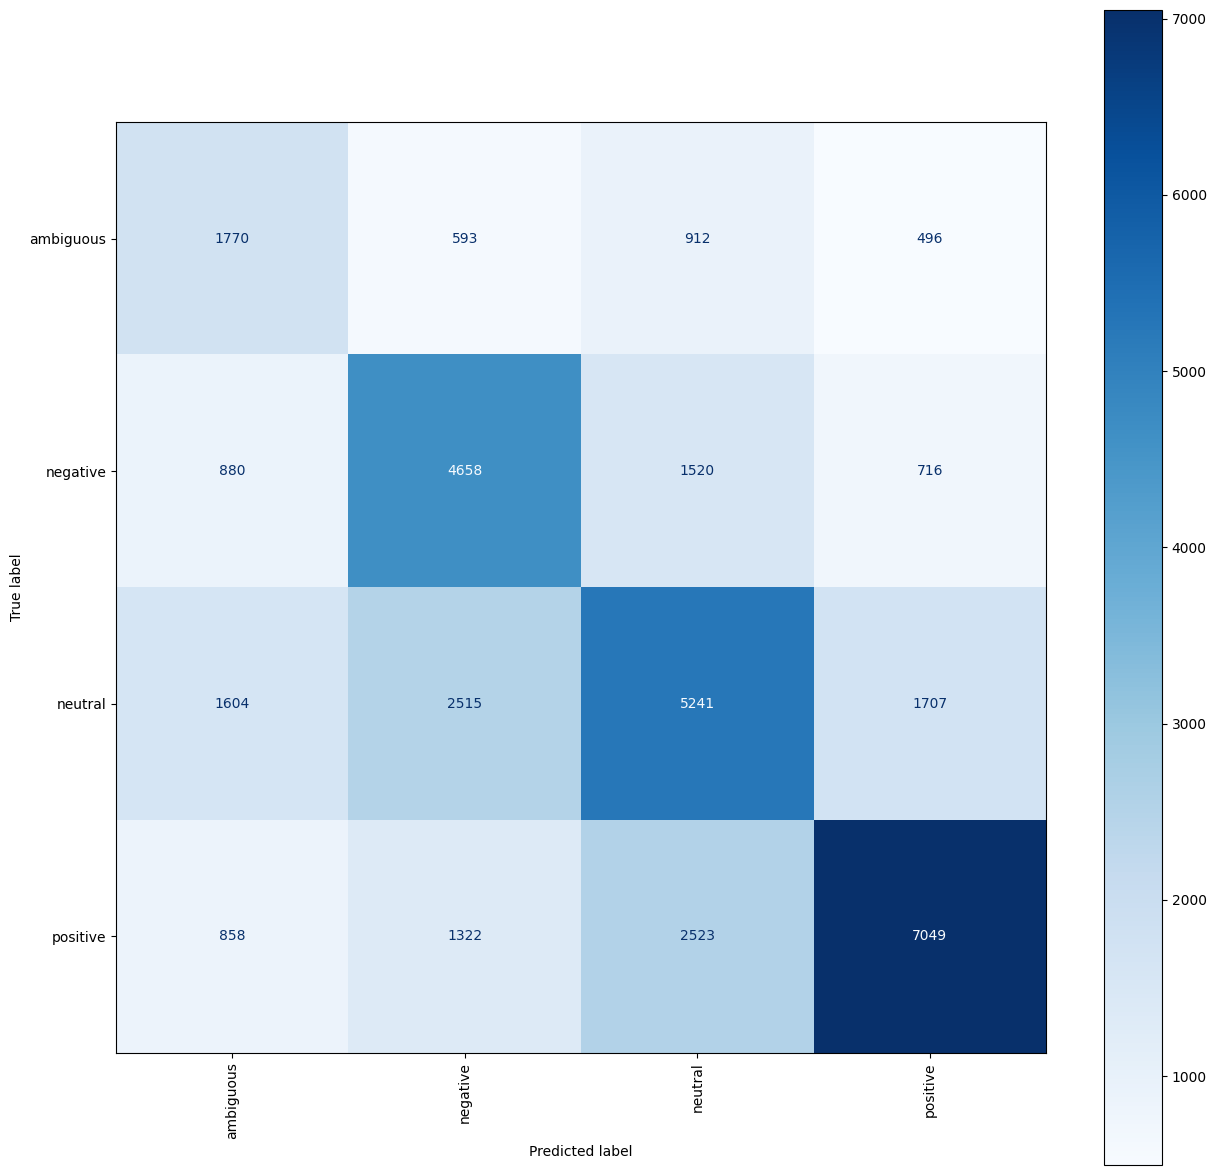

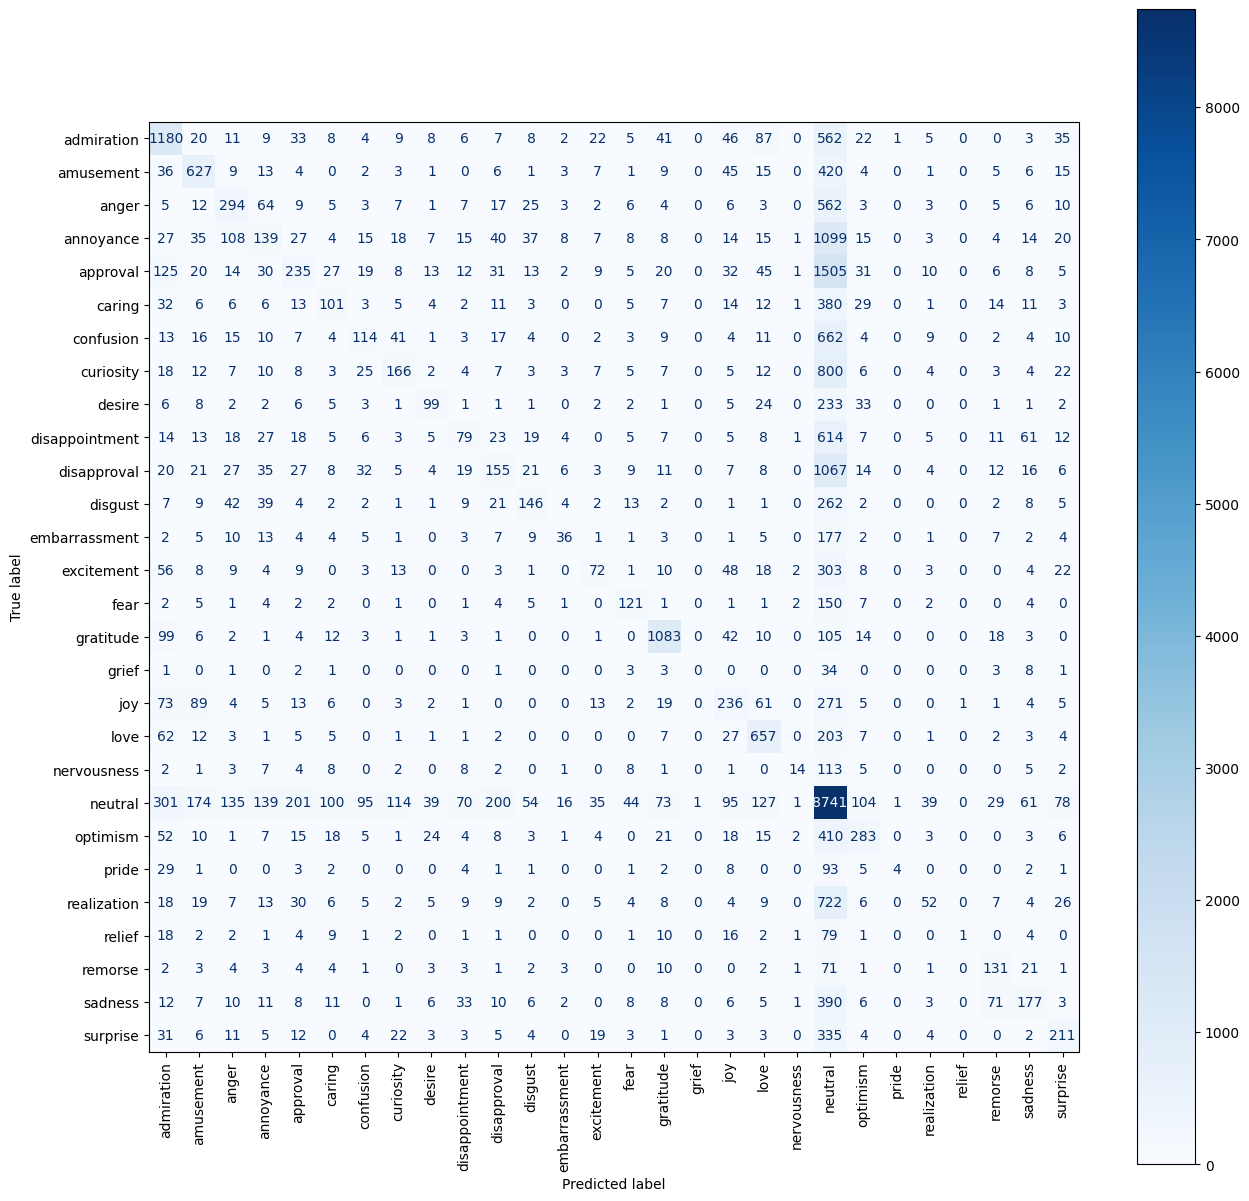

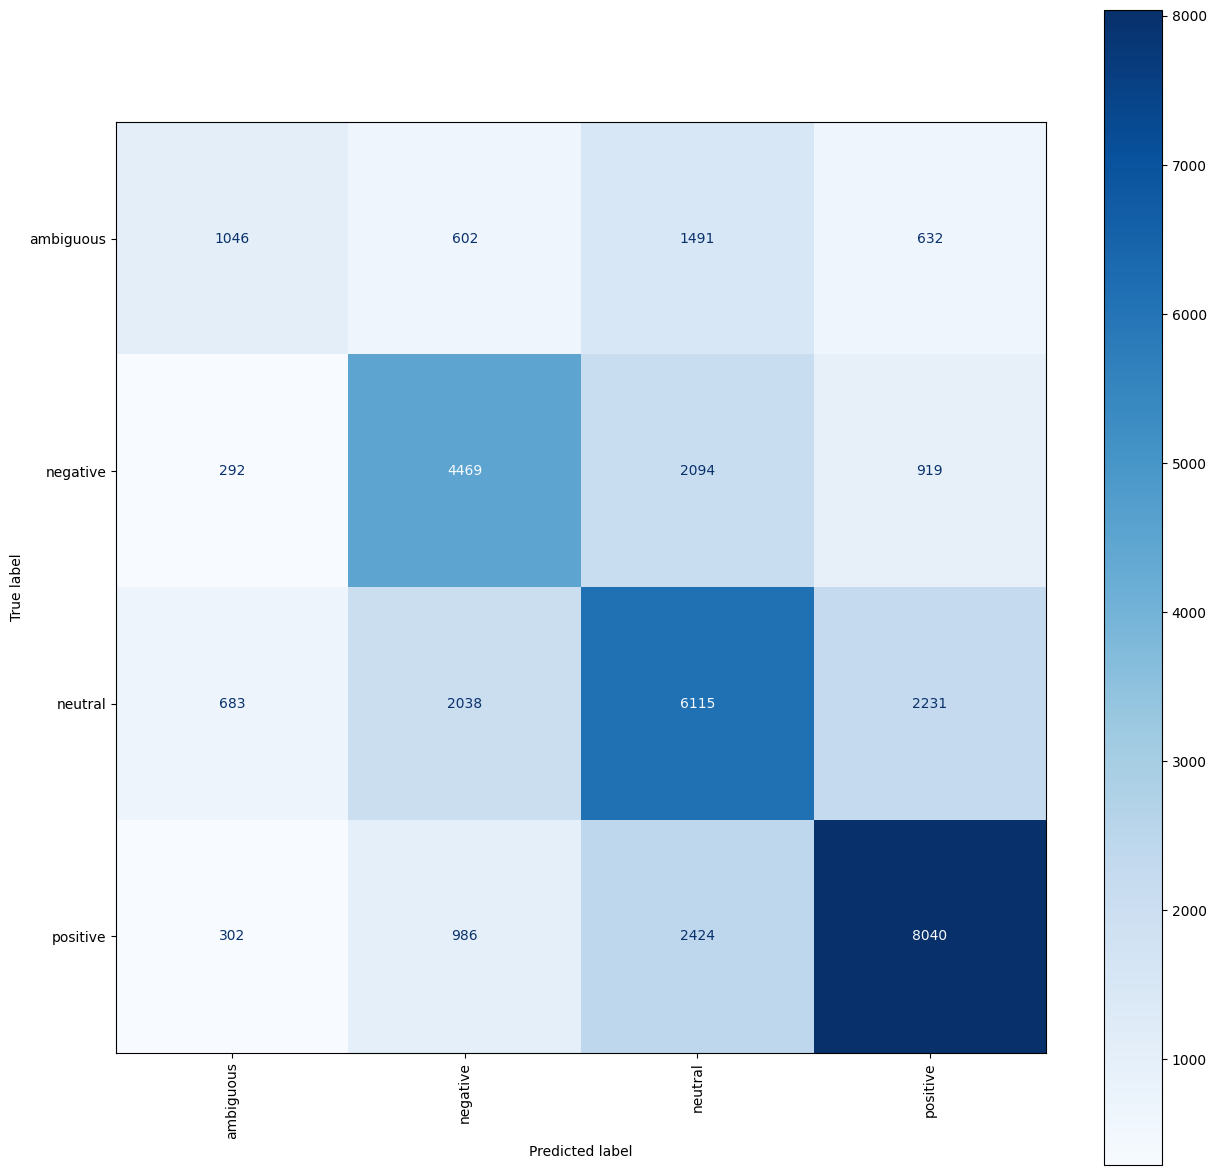

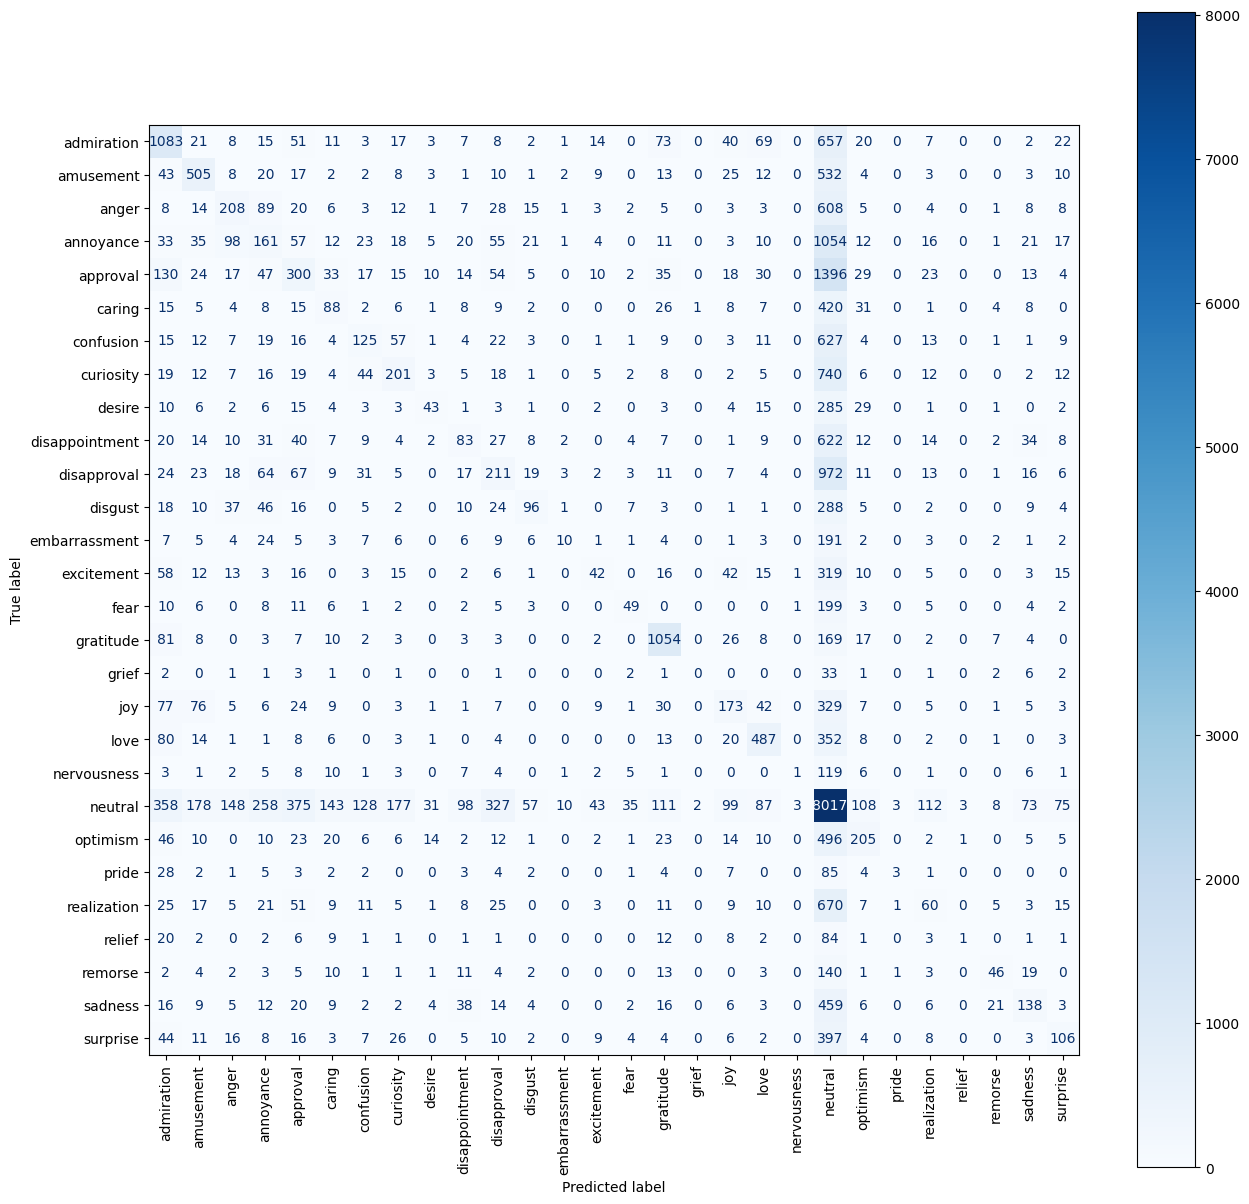

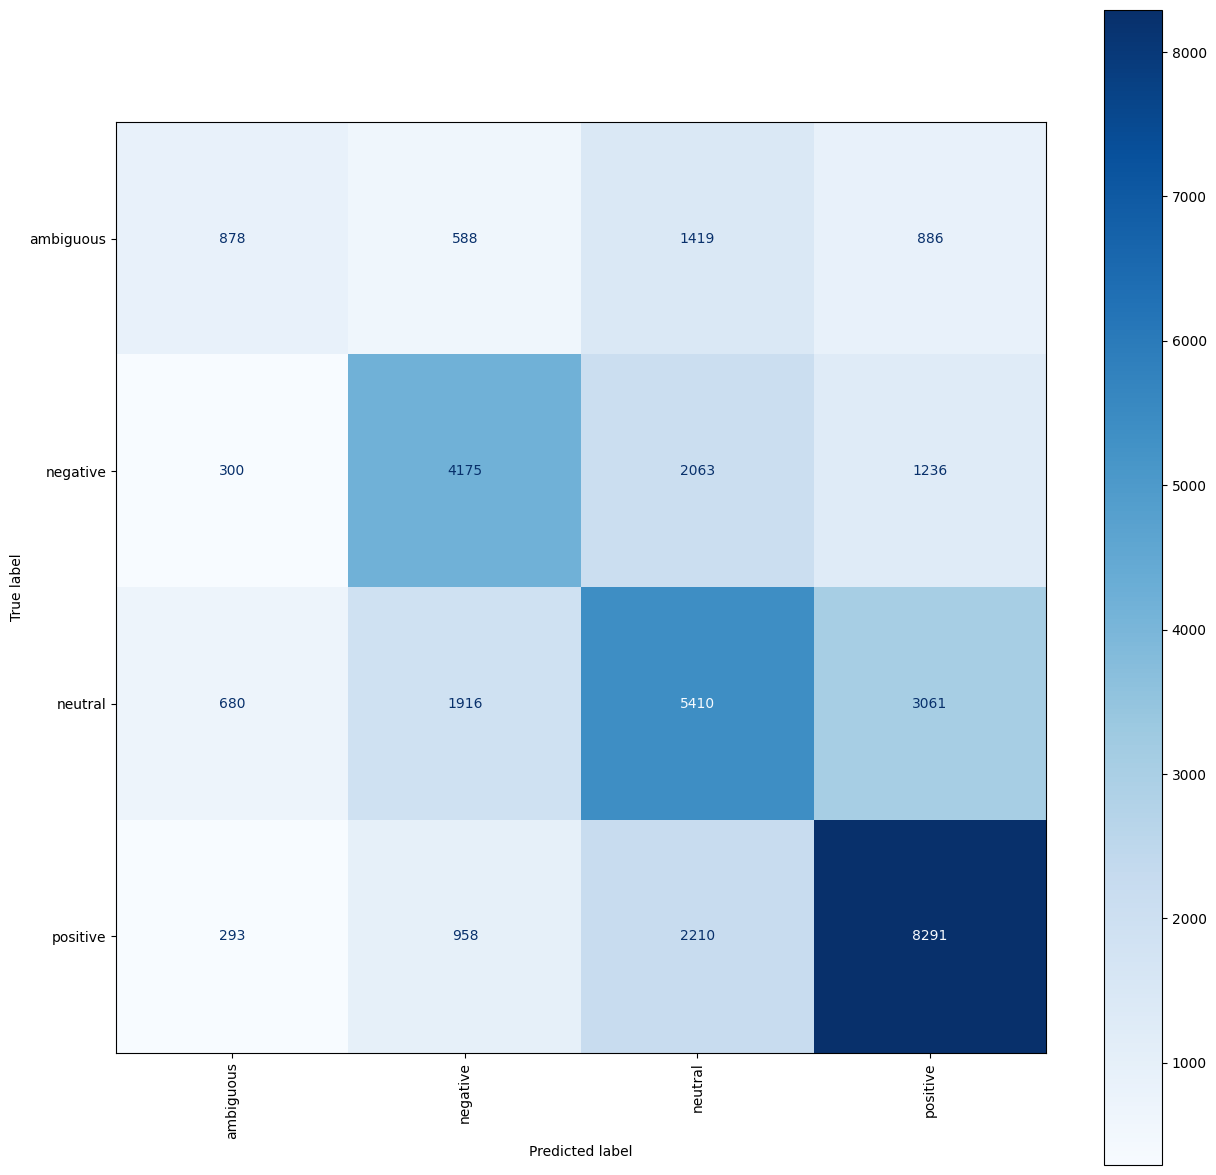

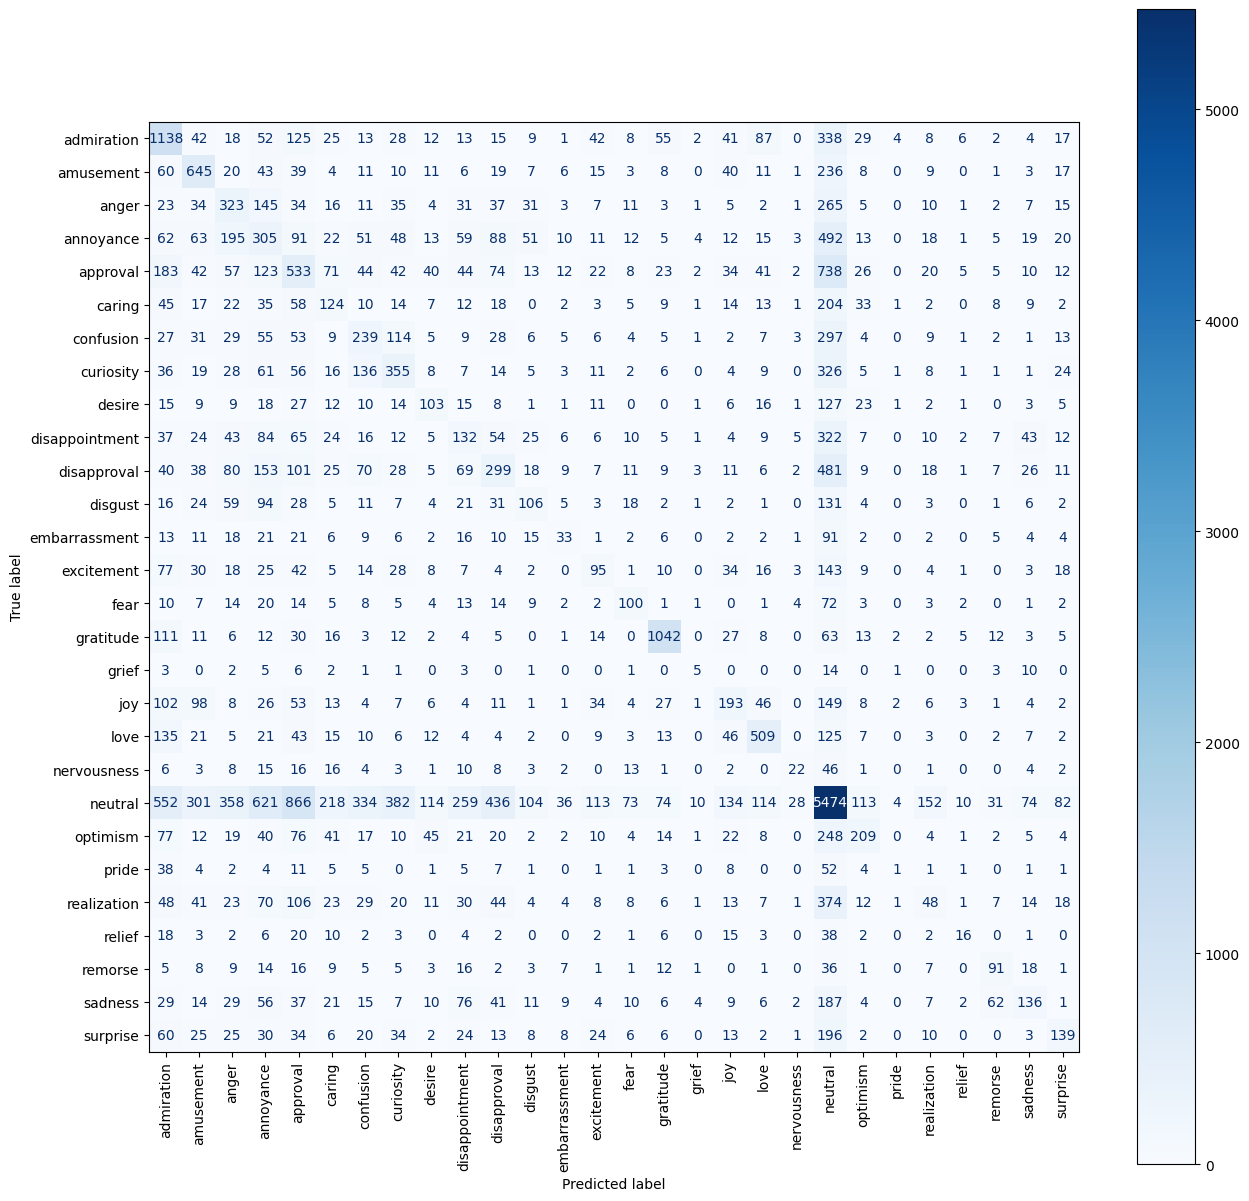

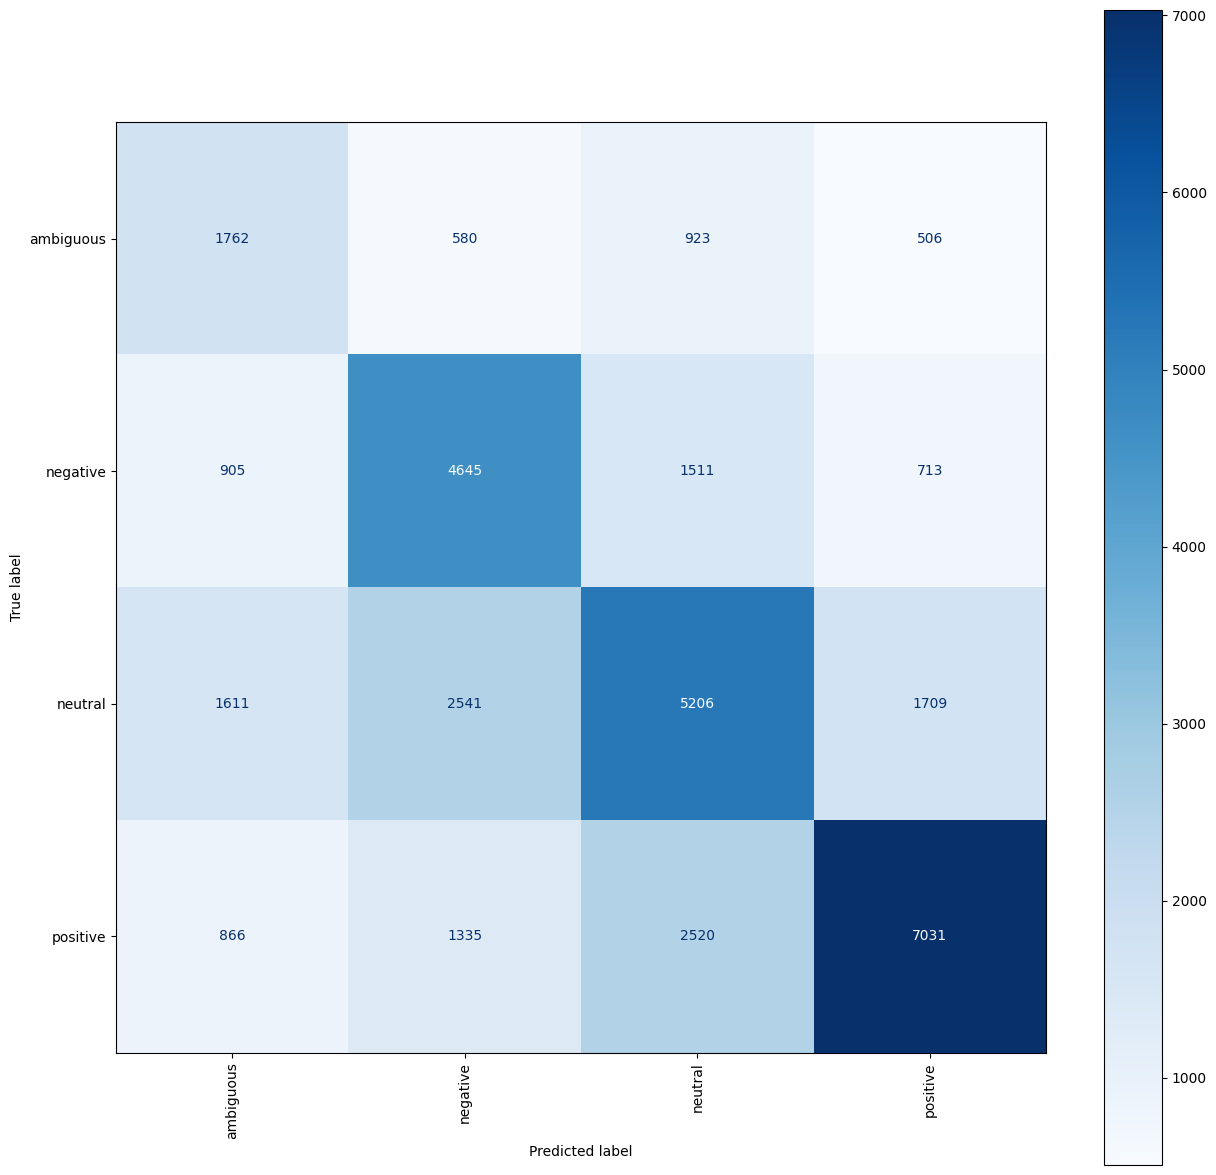

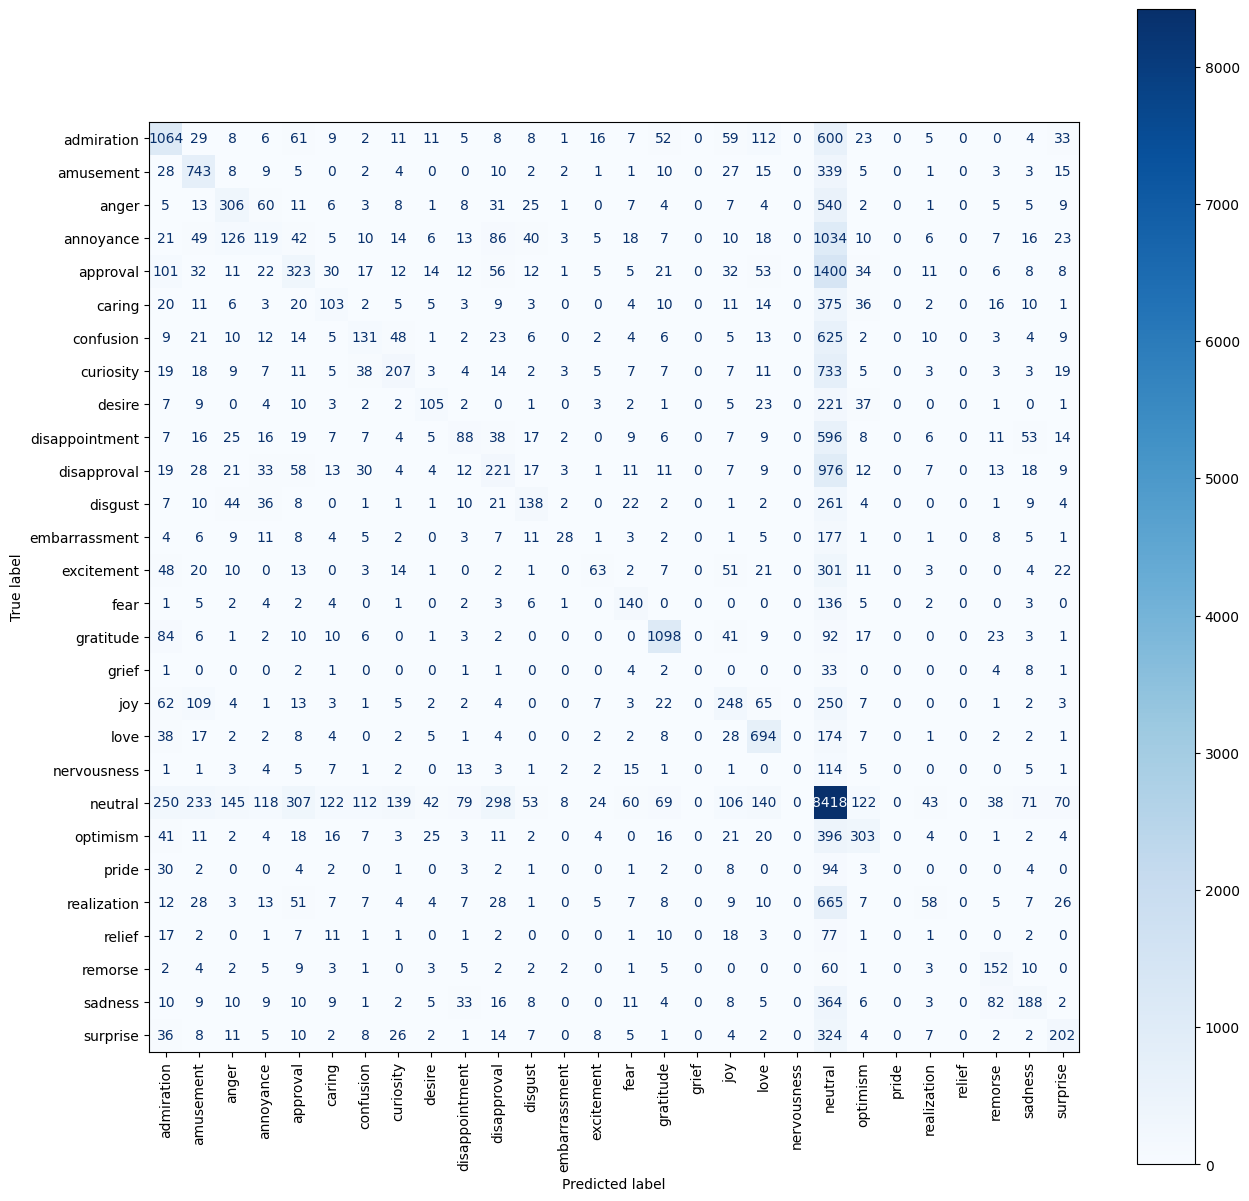

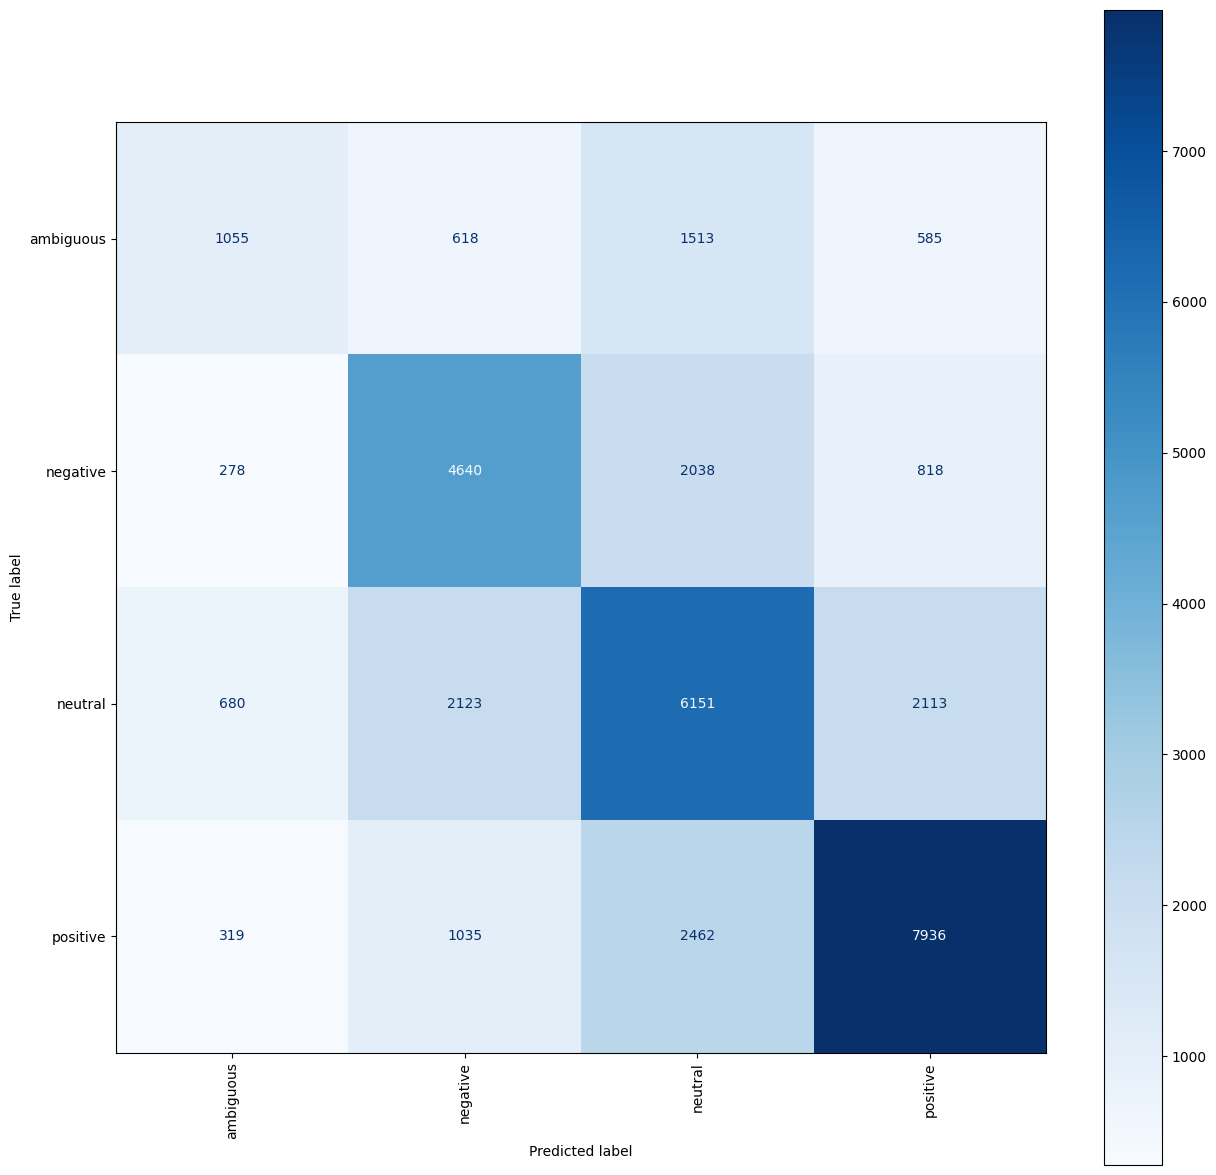

In [25]:
#BaseMNB
createPrecisionReport(modelName = "base_MultinomialNB", emotions_pred = emotions_baseMNB_pred, sentiments_pred = sentiments_baseMNB_pred, emotions_classifier = emotions_baseMNB_classifier, sentiments_classifier = sentiments_baseMNB_classifier)

#BaseDT
createPrecisionReport(modelName = "base_DecisionTree", emotions_pred = emotions_baseDT_pred, sentiments_pred = sentiments_baseDT_pred, emotions_classifier = emotions_baseDT_classifier, sentiments_classifier = sentiments_baseDT_classifier)

#BaseMLP
createPrecisionReport(modelName = "base_MLP", emotions_pred = emotions_baseMLP_pred, sentiments_pred = sentiments_baseMLP_pred, emotions_classifier = emotions_baseMLP_classifier, sentiments_classifier = sentiments_baseMLP_classifier)

#TopMNB
createPrecisionReport(modelName = "top_MultinomialNB", hyperParams=mnb_params, emotions_pred = emotions_topMNB_pred, sentiments_pred = sentiments_topMNB_pred, emotions_classifier = emotions_topMNB_classifier, sentiments_classifier = sentiments_topMNB_classifier)

#TopDT
createPrecisionReport(modelName = "top_DecisionTree", hyperParams=dt_params, emotions_pred = emotions_topDT_pred, sentiments_pred = sentiments_topDT_pred, emotions_classifier = emotions_topDT_classifier, sentiments_classifier = sentiments_topDT_classifier)

#TopMLP
createPrecisionReport(modelName = "top_MLP", hyperParams=mlp_params, emotions_pred = emotions_topMLP_pred, sentiments_pred = sentiments_topMLP_pred, emotions_classifier = emotions_topMLP_classifier, sentiments_classifier = sentiments_topMLP_classifier)


# 2.5

In [29]:
comments_train_2_5, comments_test_2_5, sentiments_train_2_5, sentiments_test_2_5, emotions_train_2_5, emotions_test_2_5 = train_test_split(comments, sentiments, emotions, test_size=0.6, random_state=0)

commentsTrainVector_2_5 = vectorizer.fit_transform(comments_train_2_5)
commentsTestVector_2_5 = vectorizer.transform(comments_test_2_5)

#2.3.1
emotions_baseMNB_pred_2_5, sentiments_baseMNB_pred_2_5, emotions_baseMNB_classifier_2_5, sentiments_baseMNB_classifier_2_5 = getBaseClassifiersPredictions(MultinomialNB(), commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

#2.3.2
emotions_baseDT_pred_2_5, sentiments_baseDT_pred_2_5, emotions_baseDT_classifier_2_5, sentiments_baseDT_classifier_2_5 = getBaseClassifiersPredictions(DecisionTreeClassifier(), commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

#2.3.3
emotions_baseMLP_pred_2_5, sentiments_baseMLP_pred_2_5, emotions_baseMLP_classifier_2_5, sentiments_baseMLP_classifier_2_5 = getBaseClassifiersPredictions(MLPClassifier(max_iter=2), commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

 #2.3.4
mnb_classifier = MultinomialNB()
emotions_topMNB_pred_2_5, sentiments_topMNB_pred_2_5, emotions_topMNB_classifier_2_5, sentiments_topMNB_classifier_2_5 = getGridSearchWithModelAndParams(mnb_classifier, mnb_params, 10, 2, commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

#2.3.5
dt_classifier = DecisionTreeClassifier()
emotions_topDT_pred_2_5, sentiments_topDT_pred_2_5, emotions_topDT_classifier_2_5, sentiments_topDT_classifier_2_5 = getGridSearchWithModelAndParams(dt_classifier, dt_params, 5, 2, commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

#2.3.6
mlp_classifier = MLPClassifier()
emotions_topMLP_pred_2_5, sentiments_topMLP_pred_2_5, emotions_topMLP_classifier_2_5, sentiments_topMLP_classifier_2_5 = getGridSearchWithModelAndParams(mlp_classifier, mlp_params, 5, 2, commentsTrainVector_2_5, commentsTestVector_2_5, sentiments_train_2_5, emotions_train_2_5)

#BaseMNB
createPrecisionReport(modelName = "base_MultinomialNB_2.5", emotions_pred = emotions_baseMNB_pred_2_5, sentiments_pred = sentiments_baseMNB_pred, emotions_classifier = emotions_baseMNB_classifier_2_5, sentiments_classifier = sentiments_baseMNB_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)

#BaseDT
createPrecisionReport(modelName = "base_DecisionTree_2.5", emotions_pred = emotions_baseDT_pred_2_5, sentiments_pred = sentiments_baseDT_pred_2_5, emotions_classifier = emotions_baseDT_classifier_2_5, sentiments_classifier = sentiments_baseDT_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)

#BaseMLP
createPrecisionReport(modelName = "base_MLP_2.5", emotions_pred = emotions_baseMLP_pred_2_5, sentiments_pred = sentiments_baseMLP_pred_2_5, emotions_classifier = emotions_baseMLP_classifier, sentiments_classifier = sentiments_baseMLP_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)

#TopMNB
createPrecisionReport(modelName = "top_MultinomialNB_2.5", hyperParams=mnb_params, emotions_pred = emotions_topMNB_pred_2_5, sentiments_pred = sentiments_topMNB_pred_2_5, emotions_classifier = emotions_topMNB_classifier_2_5, sentiments_classifier = sentiments_topMNB_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)

#TopDT
createPrecisionReport(modelName = "top_DecisionTree_2.5", hyperParams=dt_params, emotions_pred = emotions_topDT_pred_2_5, sentiments_pred = sentiments_topDT_pred_2_5, emotions_classifier = emotions_topDT_classifier_2_5, sentiments_classifier = sentiments_topDT_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)

#TopMLP
createPrecisionReport(modelName = "top_MLP_2.5", hyperParams=mlp_params, emotions_pred = emotions_topMLP_pred_2_5, sentiments_pred = sentiments_topMLP_pred_2_5, emotions_classifier = emotions_topMLP_classifier_2_5, sentiments_classifier = sentiments_topMLP_classifier_2_5, emotions_test= emotions_test_2_5, sentiments_test= sentiments_test_2_5)


['neutral' 'neutral' 'neutral' ... 'gratitude' 'neutral' 'neutral']
['neutral' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']
['neutral' 'neutral' 'neutral' ... 'gratitude' 'disapproval' 'neutral']
['neutral' 'neutral' 'ambiguous' ... 'positive' 'negative' 'neutral']
['neutral' 'neutral' 'neutral' ... 'gratitude' 'neutral' 'neutral']
['neutral' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']
  param_alpha
0           0
1         0.5
2           1
3          10
0.36867060024827625
{'alpha': 0.5}
['neutral' 'neutral' 'neutral' ... 'gratitude' 'neutral' 'neutral']
  param_alpha
0           0
1         0.5
2           1
3          10
0.5224506309974056
{'alpha': 1}
['neutral' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']
  param_criterion param_max_depth param_min_samples_split
0         entropy            1500                       4
1         entropy            1500                       6
2         entropy            1500                       8
3       

KeyboardInterrupt: 